# Data extraction and cleaning for OpenDengue
### Author: Hailey Robertson
### Date: 2024-09-24
### Citations:
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. A global dataset of publicly available dengue case count data. Sci Data. 2024 Mar 14;11(1):296.
- Clarke J, Lim A, Gupte P, Pigott DM, van Panhuis WG, Brady OJ. OpenDengue: data from the OpenDengue database. Version [1.2]. figshare; 2023. Available from: https://doi.org/10.6084/m9.figshare.24259573.


### DONE 
- find NAs at adm2 and adm1 compared to adm0 (8% missing adm1, 44% missing adm2)
- zero-filling – zeroes were most likely previously NAs, but not necessarily 
- dates to dates
- floats to floats
- match on iso3
- observed reporting period differences (1 year, 30 days, 1 week)
- combined place column + geocode


## Imports and constants

In [1]:
# Imports
import requests
import pandas as pd
from datetime import datetime
import os
import numpy as np
import geopandas as gpd
import country_converter as coco
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import ListedColormap
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import font_manager
import seaborn as sns
from brokenaxes import brokenaxes
from geopy.geocoders import Nominatim
import pickle
import time
from dotenv import load_dotenv

load_dotenv()

False

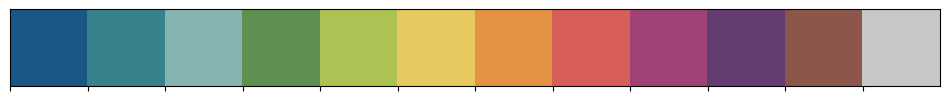

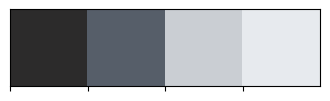

In [2]:
colors = ['#1A5784', '#38828C', '#84B5B2', '#60904F', '#ACC253', '#E7C960', '#E49243', '#D75F58', '#A04275', '#633D71', '#8c564b', '#c7c7c7']
sns.palplot(sns.color_palette(colors))

# Define chart color palette
chart = ['#2C2B2B','#565E69','#CACED3','#E7EAEE']
sns.palplot(sns.color_palette(chart))

# Define constants
figure_size = (20,6)

# Set background
sns.set_context('talk') #change the size from small to medium
sns.set_style('white') #change bg to white

# Add every font at the specified location
font_dir = ['/Users/haileyrobertson/Library/Fonts']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
    
# Set font family globally
plt.rcParams['font.family'] = 'Open Sans'
plt.rcParams['font.weight'] = 'bold'

# Set margins
plt.rcParams['axes.xmargin'] = 0.1
plt.rcParams['axes.ymargin'] = 0.1

# Define list of date formats
zfmts = ['', '%Y','%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']

# Format axes 
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = True
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.axisbelow'] = True
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['axes.titlepad'] = 30

# Format ticks
plt.rcParams["xtick.direction"] = "out"
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.minor.size'] = 10
plt.rcParams['xtick.bottom'] = True
plt.rcParams['xtick.color'] = chart[2]
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['xtick.labelcolor'] = chart[1]
plt.rcParams['xtick.labelsize'] = 8

plt.rcParams["ytick.direction"] = "in"
plt.rcParams["ytick.major.pad"] = 0
plt.rcParams["ytick.minor.pad"] = 0
plt.rcParams["ytick.major.size"] = 10
plt.rcParams["ytick.minor.size"] = 10
plt.rcParams["ytick.color"] = chart[2]
plt.rcParams["ytick.major.width"] = 0.1
plt.rcParams["ytick.minor.width"] = 0.1
plt.rcParams["ytick.labelcolor"] = chart[1]
plt.rcParams["ytick.labelsize"] = 8


# Adjust fontdict for title
titlefont = {'family': 'Open Sans',
             'color':  chart[0], 
             'weight': 400,
             'size': 20}

# Set grid style
plt.rcParams['grid.color'] = chart[2]
plt.rcParams['grid.linestyle'] = 'dashed'
plt.rcParams['grid.linewidth']=0.5

# Set legend style
plt.rcParams['legend.frameon'] = False
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.handlelength'] = 1
plt.rcParams['legend.handleheight'] = 1.125



# Set axis labels
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.labelcolor'] = chart[1]

## Cleaning

In [9]:
# Get data from master repo, reset index to access adm_0_name
url = 'https://raw.githubusercontent.com/OpenDengue/master-repo/refs/heads/main/data/raw_data/masterDB_V1.2.csv'
df = pd.read_csv(url, index_col=0, encoding='latin-1').reset_index()

# Convert unstandardized country names into iso3 codes
df["adm_0_iso3"] = coco.convert(names=df["adm_0_name"],to='ISO3', not_found="missing")

# Convert all date columns to datetime
date_cols = ['calendar_start_date', 'calendar_end_date']
df[date_cols] = df[date_cols].apply(pd.to_datetime)

df.head()

,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,adm_0_iso3
0,Argentina,12.0,Salta,445.0,Oran,4781.0,2019-07-21,2019-07-27,2.0,Total,MOH-ARG-2019-Y01-00,ARG
1,Argentina,12.0,Misiones,442.0,Iguazu,4728.0,2019-09-01,2019-09-07,1.0,Total,MOH-ARG-2019-Y01-00,ARG
2,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
3,Argentina,12.0,Jujuy,438.0,Ledesma,4649.0,2019-07-14,2019-07-20,1.0,Total,MOH-ARG-2019-Y01-00,ARG
4,Argentina,12.0,Salta,445.0,Grl. Jose De San Martin,4773.0,2019-06-30,2019-07-06,3.0,Total,MOH-ARG-2019-Y01-00,ARG


In [10]:
# Check for missing iso3 (should be empty)
missing_rows = df[df["adm_0_iso3"] == "missing"]
if len(missing_rows) == 0:
    print("No missing values!")
else:
    print(missing_rows)

country_dict = dict(zip(df['adm_0_iso3'], df['adm_0_name']))

# Group by 'adm_0_iso3' and filter groups with more than one unique 'adm_0_name'
duplicates = df.groupby('adm_0_iso3').filter(lambda x: x['adm_0_name'].nunique() > 1)

# Get the iso3 codes that have more than one country name
problematic_iso3_codes = duplicates['adm_0_iso3'].unique()

print("Unique ISO3 codes:", len(country_dict))
print("ISO3 codes with multiple names:", problematic_iso3_codes)

No missing values!
Unique ISO3 codes: 102
ISO3 codes with multiple names: ['DOM' 'PER' 'USA' 'VCT' 'KNA' 'ATG' 'TCA' 'TTO' 'MYS' 'FSM' 'MNP' 'PCN'
 'VNM' 'WLF']


In [11]:
# World geometry shapefile, devastating that get_path("naturalearth_lowres") was deprecated 
world = gpd.read_file("../data/ne_110m_admin_0_countries")
# print(world.columns.tolist())
world = world.rename(columns={"ADM0_A3":"adm_0_iso3",
                              "ADMIN":"adm_0_name",
                              "REGION_UN":"region_un",
                              "geometry":"adm_0_geometry"})
cols = ['adm_0_iso3','adm_0_name','region_un','adm_0_geometry']
world = world[cols]
world = world.sort_values(by="adm_0_name")

# Fix known issues in geopandas
world.loc[world['adm_0_name'] == 'France', 'adm_0_iso3'] = 'FRA'
world.loc[world['adm_0_name'] == 'Norway', 'adm_0_iso3'] = 'NOR'
world.loc[world['adm_0_name'] == 'Somaliland', 'adm_0_iso3'] = 'SOM'
world.loc[world['adm_0_name'] == 'Kosovo', 'adm_0_iso3'] = 'RKS'

In [12]:
# Merge geometry, keeping nulls
open_dengue = pd.merge(df,world,on='adm_0_iso3',how='outer')

# Fill adm_0_name_x with values from adm_0_name_y if it is empty
open_dengue['adm_0_name'] = open_dengue['adm_0_name_x'].where(open_dengue['adm_0_name_x'].notna() & (open_dengue['adm_0_name_x'] != ''), open_dengue['adm_0_name_y'])

# Drop the original _x and _y columns
open_dengue = open_dengue.drop(columns=['adm_0_name_x', 'adm_0_name_y'])

# Move adm_0_name and adm_0_iso3 to the front
columns = ['adm_0_name', 'adm_0_iso3'] + [col for col in open_dengue.columns if col not in ['adm_0_name', 'adm_0_iso3']]
open_dengue = open_dengue[columns]

print("Number of ISO3 codes: ", len(open_dengue.adm_0_iso3.unique()))
print("regions: ", open_dengue.region_un.unique())

Number of ISO3 codes:  220
regions:  [nan 'Asia' 'Africa' 'Europe' 'Americas' 'Antarctica' 'Oceania']


In [13]:
# Check UN region
missing_un_region = open_dengue[open_dengue['region_un'].isna()]
print(missing_un_region.adm_0_name.unique())
# Fill with 'Other' for now
open_dengue['region_un'] = open_dengue['region_un'].fillna("Other")

['Aruba' 'Anguilla' 'American Samoa' 'Antigua and Barbuda'
 'Antigua And Barbuda' 'Bonaire, Saint Eustatius and Saba'
 'Saint Barthelemy' 'Bermuda' 'Barbados' 'Cook Islands' 'Curacao'
 'Cayman Islands' 'Dominica' 'Micronesia (Federated States Of)' 'FSM'
 'Micronesia (Federated States of)' 'Guadeloupe' 'Grenada' 'French Guiana'
 'Guam' 'Hong Kong' 'Kiribati' 'Saint Kitts and Nevis'
 'Saint Kitts And Nevis' 'Saint Lucia' 'Macau' 'Saint Martin' 'Maldives'
 'Marshall Islands' 'Northern Mariana Islands' 'N Mariana Is' 'Montserrat'
 'Martinique' 'Niue' 'Nauru' 'Pitcairn' 'Pitcairn Islands' 'Palau'
 'French Polynesia' 'Singapore' 'Sint Maarten' 'Turks and Caicos Islands'
 'Turks And Caicos Islands' 'Tokelau' 'Tonga' 'Tuvalu'
 'Saint Vincent and the Grenadines' 'Saint Vincent And The Grenadines'
 'Virgin Islands (UK)' 'Virgin Islands (US)' 'Wallis And Futuna'
 'Wallis and Futuna' 'Wallis & Futuna' 'Samoa']


In [14]:
# Extract year from calendar_start_date
open_dengue['year'] = open_dengue['calendar_start_date'].dt.year

#  Not all periods are the same length – some places report every year, some every month, some every week
open_dengue["date_diff"] = (open_dengue["calendar_end_date"] - open_dengue["calendar_start_date"]).dt.days

# Find geo resolution and combine places
def highest_geo_resolution(row):
    if pd.notna(row['adm_2_name']) and row['adm_2_name'] != '':
        return 'adm_2'
    elif pd.notna(row['adm_1_name']) and row['adm_1_name'] != '':
        return 'adm_1'
    else:
        return 'adm_0'

open_dengue['geo_resolution'] = open_dengue.apply(highest_geo_resolution, axis=1)

open_dengue['combined_place'] = open_dengue[['adm_2_name', 'adm_1_name', 'adm_0_name']].apply(
    lambda x: ', '.join([str(place) for place in x if pd.notna(place) and place != '']), axis=1)

In [33]:
open_dengue.tail()

,adm_0_name,adm_0_iso3,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,region_un,adm_0_geometry,year,date_diff,geo_resolution,combined_place
391543,Yemen,YEM,NaN,NaN,NaN,NaN,NaN,2021-06-27,2021-07-03,51.0,Suspected,WHOEMRO-ALL-2021-Y01-05,Asia,"POLYGON ((52.00001 19, 52.78218 17.34974, 53.1...",2021.0,6.0,adm_0,Yemen
391544,Yemen,YEM,NaN,NaN,NaN,NaN,NaN,2021-07-11,2021-07-17,52.0,Suspected,WHOEMRO-ALL-2021-Y01-05,Asia,"POLYGON ((52.00001 19, 52.78218 17.34974, 53.1...",2021.0,6.0,adm_0,Yemen
391545,South Africa,ZAF,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Africa,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",NaN,NaN,adm_0,South Africa
391546,Zambia,ZMB,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Africa,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",NaN,NaN,adm_0,Zambia
391547,Zimbabwe,ZWE,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,Africa,"POLYGON ((31.19141 -22.25151, 30.65987 -22.151...",NaN,NaN,adm_0,Zimbabwe


## Export

In [26]:
# # Save the DataFrame as a CSV file – too big to commit!
# open_dengue.to_csv("../data/open_dengue_v1_2.csv", index=False)

## Figs

### Temporal and geographic resolution

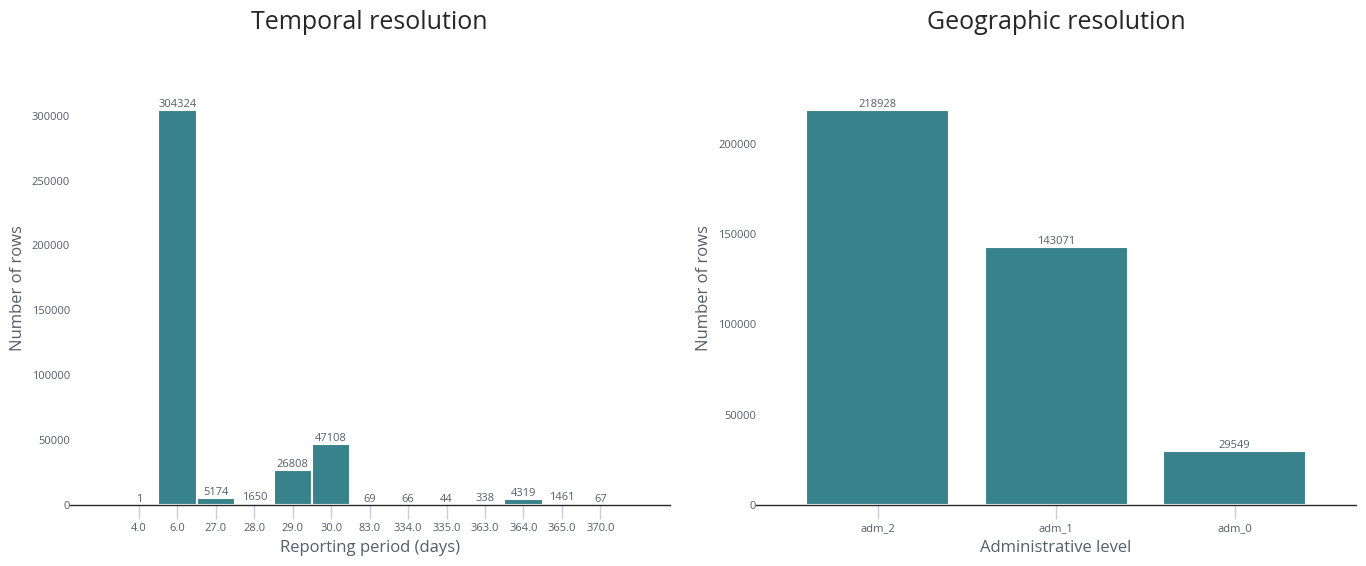

In [17]:
# Create the figure and two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# First subplot: Number of rows by reporting period

trying = pd.Categorical(open_dengue['date_diff'])
reporting_period_counts = pd.Series(trying).value_counts().sort_index()
# reporting_period_counts = open_dengue['date_diff'].value_counts().sort_index()

bars = ax1.bar(reporting_period_counts.index.astype(str), reporting_period_counts.values, color = colors[1], width = 1)

# Adding height labels above each bar
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])


ax1.set_title('Temporal resolution')
ax1.set_xlabel('Reporting period (days)')
ax1.set_ylabel('Number of rows')

# Second subplot: Number of rows by geographic resolution
geo_resolution_counts = open_dengue['geo_resolution'].value_counts()
bars2 = ax2.bar(geo_resolution_counts.index, geo_resolution_counts.values, color=colors[1])

for bar2 in bars2:
    height = bar2.get_height()
    ax2.text(bar2.get_x() + bar2.get_width() / 2, height, f'{int(height)}', ha='center', va='bottom', fontsize=8, color=chart[1])

ax2.set_title('Geographic resolution')
ax2.set_xlabel('Administrative level')
ax2.set_ylabel('Number of rows')

# Display the plots
plt.tight_layout()
plt.show()

### Cases over time
- Roll up to adm0
- Roll up to year
- Include all cases (total, suspected, probable)
- Occurrence map (1+ cases of dengue ever)
- Incidence (new cases over time by country, plot all of them in line chart...and then pull out some interesting examples???)
- Seasonal incidence circular plot....

#### Questions:
- up until what year are open dengue data reliable? e.g., is 2020 complete?

In [35]:
# Fill the years so that ISO3s stay
years = pd.Series(range(int(1950), int(open_dengue['year'].max()) + 1))
unique_iso3 = open_dengue['adm_0_iso3'].unique()

all_combinations = pd.MultiIndex.from_product([unique_iso3, years], names=['adm_0_iso3', 'year']).to_frame(index=False)

open_dengue_rollup = all_combinations.merge(open_dengue, on=['adm_0_iso3', 'year'], how='outer')
open_dengue_rollup

,adm_0_iso3,year,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,region_un,adm_0_geometry,date_diff,geo_resolution,combined_place
0,ABW,1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
1,ABW,1951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,ABW,1952.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
3,ABW,1953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
4,ABW,1954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404457,ZWE,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
404458,ZWE,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
404459,ZWE,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
404460,ZWE,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [ ]:
# Merge with population size per year
pop = pd.read_csv("../data/WPP2022_Demographic_Indicators_Medium.csv", dtype={'Time': float,'TPopulation1July':float}, low_memory=False)
columns = ['ISO3_code','Time','TPopulation1July']
pop = pop[columns]


dengue_pop = open_dengue.merge(pop,left_on=['adm_0_iso3','year'],right_on=['ISO3_code','Time'],how='left')
dengue_pop.drop(columns[:-1],axis=1,inplace=True)
dengue_pop = dengue_pop.dropna(subset=['adm_0_iso3'])
dengue_pop

,adm_0_iso3,year,adm_0_name,adm_0_code,adm_1_name,adm_1_code,adm_2_name,adm_2_code,calendar_start_date,calendar_end_date,dengue_total,case_definition_standardised,UUID,region_un,adm_0_geometry,date_diff,geo_resolution,combined_place,TPopulation1July
0,ABW,1950.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,38.798
1,ABW,1951.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,40.231
2,ABW,1952.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,41.758
3,ABW,1953.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,43.305
4,ABW,1954.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,44.869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
404457,ZWE,2020.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,15669.666
404458,ZWE,2021.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,15993.524
404459,ZWE,2022.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,16320.537
404460,ZWE,2023.0,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,16665.409


In [22]:
# Fill problematic NAs
dengue_pop['dengue_total'] = dengue_pop['dengue_total'].fillna(0)

# Fix region
def get_primary_region(group):
    # Exclude 'Other' and NaN, then get the unique region value if it exists
    non_other_values = group.loc[~group.isin(['Other', np.nan])]
    if not non_other_values.empty:
        return non_other_values.iloc[0]  # Take the first valid entry if it exists
    return 'Other'  # Default to 'Other' if no valid value is found

# Apply this function to each country group to fill `region_un`
dengue_pop['region_un'] = dengue_pop.groupby('adm_0_iso3')['region_un'].transform(get_primary_region)

dengue_pop = dengue_pop.groupby(['adm_0_iso3', 'year','region_un','TPopulation1July']).agg({
    'dengue_total': 'sum'
}).reset_index()

dengue_pop.head()

,adm_0_iso3,year,region_un,TPopulation1July,dengue_total
0,ABW,1950.0,Other,38.798,0.0
1,ABW,1951.0,Other,40.231,0.0
2,ABW,1952.0,Other,41.758,0.0
3,ABW,1953.0,Other,43.305,0.0
4,ABW,1954.0,Other,44.869,0.0


In [23]:
# Calculate incidence
dengue_pop['TPopulation1July'] = dengue_pop['TPopulation1July'] * 1000
dengue_pop['incidence'] = dengue_pop['dengue_total'] / dengue_pop['TPopulation1July']

dengue_pop.sort_values(by="incidence", ascending=False)
dengue_pop.head()

,adm_0_iso3,year,region_un,TPopulation1July,dengue_total,incidence
0,ABW,1950.0,Other,38798.0,0.0,0.0
1,ABW,1951.0,Other,40231.0,0.0,0.0
2,ABW,1952.0,Other,41758.0,0.0,0.0
3,ABW,1953.0,Other,43305.0,0.0,0.0
4,ABW,1954.0,Other,44869.0,0.0,0.0


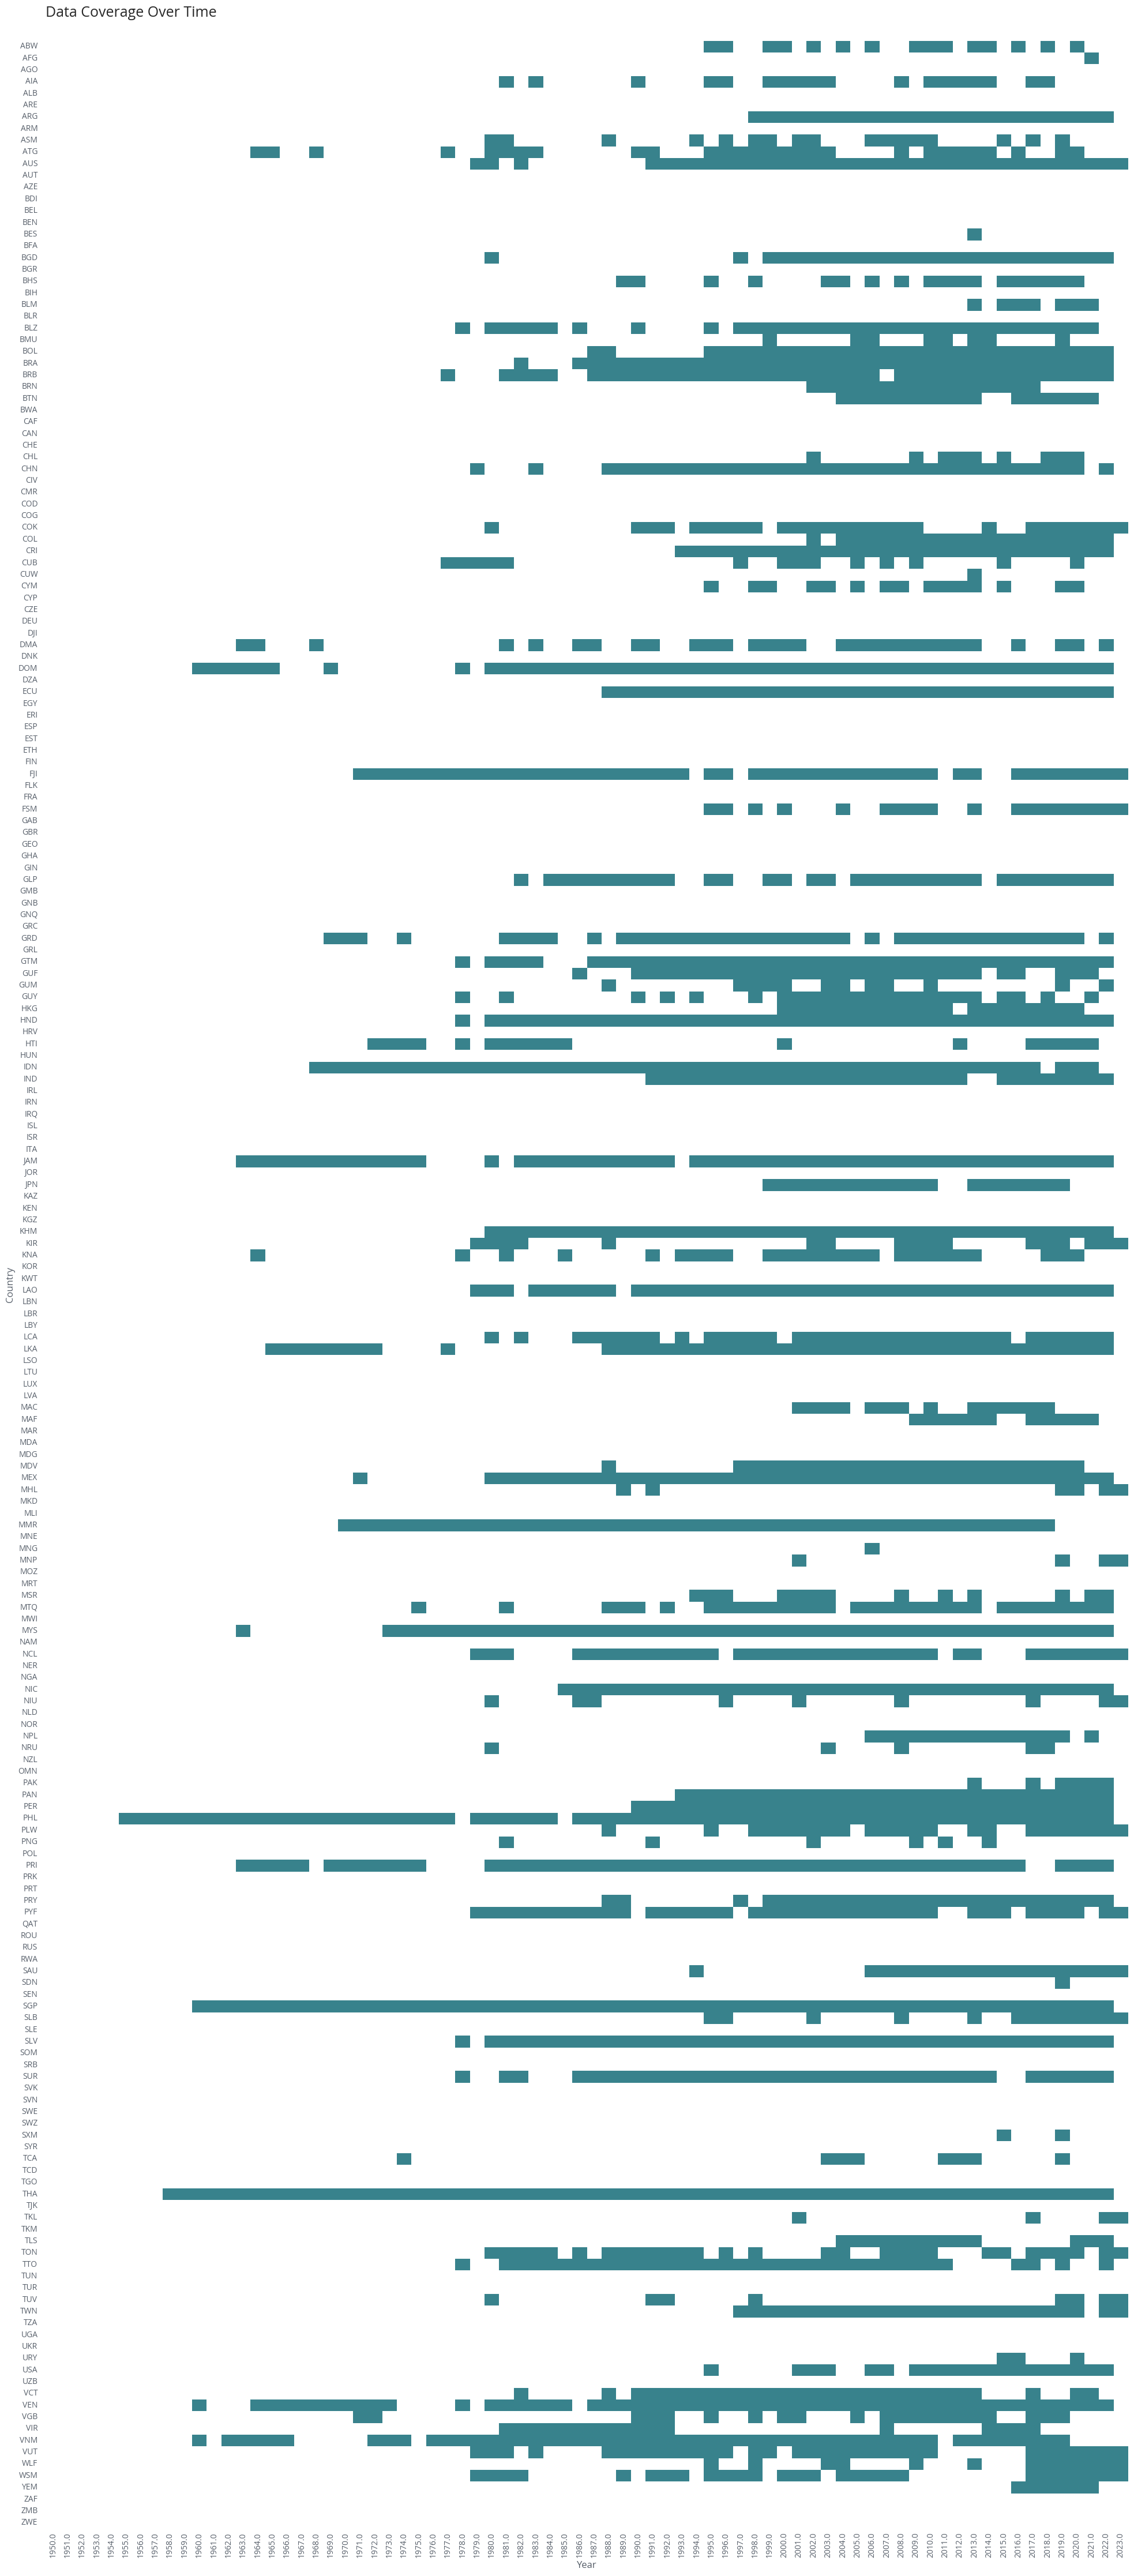

In [26]:
heatmap_data = dengue_pop.pivot(index='adm_0_iso3', columns='year', values='incidence').fillna(0)

binary_heatmap_data = np.where(heatmap_data == 0, 0, 1)

binary_heatmap_data = pd.DataFrame(binary_heatmap_data, index=dengue_pop['adm_0_iso3'].unique(), columns=dengue_pop['year'].unique())

binary_heatmap_data = binary_heatmap_data.sort_index()

# Plot

fig, ax = plt.subplots(figsize=(20, 45))  # Adjust size as needed

custom_colors = ["white", colors[1]]


# Plot the heatmap
im = sns.heatmap(data=binary_heatmap_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0, ax=ax, vmin=0, vmax=1, cbar=False)

# Set tick labels and axis labels
ax.set_xlabel('Year')
ax.set_ylabel('Country')
ax.set_title("Data Coverage Over Time",loc='left')

# Set tick parameters
ax.tick_params(axis='x', pad=5, length=0, labelsize=10, width=30)
plt.setp(ax.get_xticklabels(), rotation=90)

ax.tick_params(axis='y', pad=10, width=30, labelsize=10)
ax.tick_params(top=False, bottom=True, labeltop=False, labelbottom=True)

# Hide spines
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Set title and show the plot
plt.tight_layout()
plt.show()


In [ ]:
# Add presence column and pivot the data for the heatmap
dengue_pop['dengue_presence'] = (dengue_pop['dengue_total'] > 0).astype(int)
data = data.sort_values(by=['region_un', 'adm_0_iso3', 'year'])
heatmap_data = data.pivot(index=['region_un', 'adm_0_iso3'], columns='year', values='dengue_presence').fillna(0)

# Create a new index with region labels (multi-level index)
heatmap_data.index = [f"{region} - {country}" for region, country in heatmap_data.index]

# Custom colors: white for absence, blue for presence
colors = sns.color_palette("Blues", as_cmap=True)
custom_colors = ["white", colors(0.6)]

# Plot heatmap
fig, ax = plt.subplots(figsize=(20, 10))
sns.heatmap(heatmap_data, cmap=custom_colors, annot=False, fmt='g', linewidths=0.5, 
            ax=ax, vmin=0, vmax=1, cbar=False)

# Customize labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Country (Region)')
ax.set_title("Data Coverage Over Time by Region", loc='left', fontsize=16)

# Set x-axis tick rotation and y-axis label size
plt.setp(ax.get_xticklabels(), rotation=90)
ax.tick_params(axis='y', labelsize=10)

# Remove spines for a cleaner look
ax.spines.bottom.set_visible(False)
ax.spines.left.set_visible(False)

# Tight layout
plt.tight_layout()
plt.show()


In [ ]:
# Add presence column and pivot the data for the heatmap
dengue_pop['dengue_presence'] = (dengue_pop['dengue_total'] > 0).astype(int)
dengue_pop = dengue_pop.sort_values(by=['region_un', 'adm_0_iso3', 'year'])
heatmap_data = dengue_pop.pivot(index=['region_un', 'adm_0_iso3'], columns='year', values='dengue_presence').fillna(0)
heatmap_data


year                  1950  1951  1952  1953  1954  1955  1956  1957  1958  \
region_un adm_0_iso3                                                         
Africa    SDN            0     0     0     0     0     0     0     0     0   
Americas  ARG            0     0     0     0     0     0     0     0     0   
          BHS            0     0     0     0     0     0     0     0     0   
          BLZ            0     0     0     0     0     0     0     0     0   
          BOL            0     0     0     0     0     0     0     0     0   
...                    ...   ...   ...   ...   ...   ...   ...   ...   ...   
Other     WLF            0     0     0     0     0     0     0     0     0   
          WSM            0     0     0     0     0     0     0     0     0   
          ZAF            0     0     0     0     0     0     0     0     0   
          ZMB            0     0     0     0     0     0     0     0     0   
          ZWE            0     0     0     0     0     0     0     0     0   

year                  1959  ...  2014  2015  2016  2017  2018  2019  2020  \
region_un adm_0_iso3        ...                                             
Africa    SDN            0  ...     0     0     0     0     0     1     0   
Americas  ARG            0  ...     1     1     1     1     1     1     1   
          BHS            0  ...     0     1     1     1     1     1     1   
          BLZ            0  ...     1     1     1     1     1     1     1   
          BOL            0  ...     1     1     1     1     1     1     1   
...                    ...  ...   ...   ...   ...   ...   ...   ...   ...   
Other     WLF            0  ...     0     0     0     1     1     1     1   
          WSM            0  ...     0     0     0     1     1     1     1   
          ZAF            0  ...     0     0     0     0     0     0     0   
          ZMB            0  ...     0     0     0     0     0     0     0   
          ZWE            0  ...     0     0     0     0     0     0     0   

year                  2021  2022  2023  
region_un adm_0_iso3                    
Africa    SDN            0     0     0  
Americas  ARG            1     1     0  
          BHS            0     0     0  
          BLZ            1     0     0  
          BOL            1     1     0  
...                    ...   ...   ...  
Other     WLF            1     1     1  
          WSM            1     1     1  
          ZAF            0     0     0  
          ZMB            0     0     0  
          ZWE            0     0     0  

[212 rows x 74 columns]

## Geocode

In [9]:
# # GEOCODE places (if needed)
#  user_agent = os.getenv("USER_AGENT")
# geolocator = Nominatim(user_agent=user_agent, timeout=10)

# # Load previously saved geocoded locations to avoid duplicates
# try:
#     with open('../data/cached_locations.pkl', 'rb') as f:
#         cached_locations = pickle.load(f)
# except (FileNotFoundError, EOFError):
#     cached_locations = {}

# def geocode_location(loc):
#     """Geocode the address if not already cached."""
#     if loc in cached_locations:
#         return cached_locations[loc]
#     else:
#         try:
#             location = geolocator.geocode(loc)
#             if location:
#                 # Only return latitude and longitude
#                 lat = location.latitude
#                 long = location.longitude
#                 lat_long = lat, long
#                 cached_locations[loc] = {
#                                     'latitude': lat,
#                                     'longitude': long,
#                                     'lat_long': lat_long
#                 }
#             else:
#                 cached_locations[loc] = None
#             # Save the cache after every new entry
#             with open('cached_locations.pkl', 'wb') as f:
#                 pickle.dump(cached_locations, f)
#             return cached_locations[loc]
#         except Exception as e:
#             print(f"Error geocoding {loc}: {e}")
#             return None

# locs = open_dengue["combined_place"]

# open_dengue["latitude"] = None
# open_dengue["longitude"] = None
# open_dengue["lat_long"] = None


# # Delay between requests in seconds to avoid hitting the rate limit
# REQUEST_DELAY = 0

# # Geocode locations with rate limiting and caching
# for idx, loc in enumerate(locs):
#     coords = geocode_location(loc)
    
#     if coords:
#         open_dengue.at[idx, "latitude"] = coords['latitude']
#         open_dengue.at[idx, "longitude"] = coords['longitude']
#         open_dengue.at[idx, "lat_long"] = coords['lat_long']
#         print(f"Address: {loc}, Coordinates: {coords}")
#     else:
#         print(f"Address: {loc}, Coordinates: Not found")
    
#     # Introduce delay to avoid API rate limits
#     time.sleep(REQUEST_DELAY)